
Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

%matplotlib inline

In [18]:
FILE_DIR  = '/kaggle/input/diseases/dis'                     # Папка с текстовыми файлами

In [19]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку


Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"


In [20]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [21]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [22]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Колит
  train: постоянные позывы на дефекацию, урчание, вздутие живота, профузный понос, иногда с кровью и слизью, резкие боли в животе переполнение и тяжесть в брюшной полости,  чувство сдавливания. Боли схваткообразные (колики), которые сопровождаются позывами к дефекаци   Геморрагическая диарея различной выраженности и продолжительности позывы на дефекацию,  неинтенсивная схваткообразная боль внизу живота,  примеси крови и слизи в стуле.   боль в животе диарея выделение крови из прямой кишки (гематохезия) повышение температуры тела тахикардия слабость утомляемость внекишечные проявления – поражение суставов, глаз, печени и желчевыводящих путей, полости рта.  дискомфортные ощущения в животе тупые боли в желудке,которые усиливаются при беге или ходьбе проблемы со стулом - диареи или запоры выделяемые каловые массы содержат слизистые прожилки или примеси крови ложные позывы к дефекации тяжесть в животе вздутие метеоризм  постоянные проблемы со стулом повышенное газообразование в

In [23]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [ ]:
# Функция для очистки текста
def clean_text(text):
    text = text.lower()  # Переводим текст в нижний регистр
    text = re.sub(r'[^а-яёa-z0-9 ]', ' ', text)   # Убираем все символы, кроме букв и цифр
    text = re.sub(r'\s+', ' ', text)  # Убираем лишние пробелы
    return text.strip()


In [ ]:
# Аугментация — разбивка на части
new_text_train = []
new_text_test = []
new_y_train = []
new_y_test = []

chunk_size = 50  # Кол-во слов в одном примере

In [25]:
# Разбиваем текст на части и добавляем их в новые выборки
for cls_idx, (train_text, test_text) in enumerate(zip(text_train, text_test)):
    for part, target_list, data_list in [(train_text, new_y_train, new_text_train),
                                         (test_text, new_y_test, new_text_test)]:
        words = clean_text(part).split()    # Очищаем текст и разделяем на слова
        for i in range(0, len(words) - chunk_size + 1, chunk_size):  # Разбиваем на кусочки по chunk_size слов
            chunk = ' '.join(words[i:i + chunk_size])  # Берем 50 слов за раз
            data_list.append(chunk)
            target_list.append(cls_idx) # Добавляем индекс класса

In [26]:
# Токенизация
MAX_WORDS = 5000 # Ограничиваем количество слов
MAX_LEN = 100 # Максимальная длина последовательности

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True)
tokenizer.fit_on_texts(new_text_train)

# Преобразуем текст в числовые последовательности
x_train = pad_sequences(tokenizer.texts_to_sequences(new_text_train), maxlen=MAX_LEN)
x_test = pad_sequences(tokenizer.texts_to_sequences(new_text_test), maxlen=MAX_LEN)

# Преобразуем метки классов в one-hot векторы
y_train = utils.to_categorical(new_y_train, CLASS_COUNT)
y_test = utils.to_categorical(new_y_test, CLASS_COUNT)


In [ ]:
# Модель нейронной сети
model = Sequential()
model.add(Embedding(MAX_WORDS, 64, input_length=MAX_LEN)) 
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))  # Полносвязный слой с ReLU активацией
model.add(Dropout(0.3))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Построение модели
model.build(input_shape=(None, MAX_LEN))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,810 (1.24 MB)

 Trainable params: 324,810 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Обучение модели
with timex():
    history = model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=4,
                        validation_data=(x_test, y_test),
                        verbose=1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1085 - loss: 2.2974 - val_accuracy: 0.1852 - val_loss: 2.2808
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1904 - loss: 2.2832 - val_accuracy: 0.1852 - val_loss: 2.2639
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1830 - loss: 2.2572 - val_accuracy: 0.1852 - val_loss: 2.2474
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1325 - loss: 2.2352 - val_accuracy: 0.1852 - val_loss: 2.2210
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1952 - loss: 2.1929 - val_accuracy: 0.1852 - val_loss: 2.1964
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1876 - loss: 2.1486 - val_accuracy: 0.1852 - val_loss: 2.1697
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2194 - loss: 2.0522 - val_accuracy: 0.1852 - val_loss: 2.1341
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3112 - loss: 2.0309 - val_accuracy: 0.2222 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


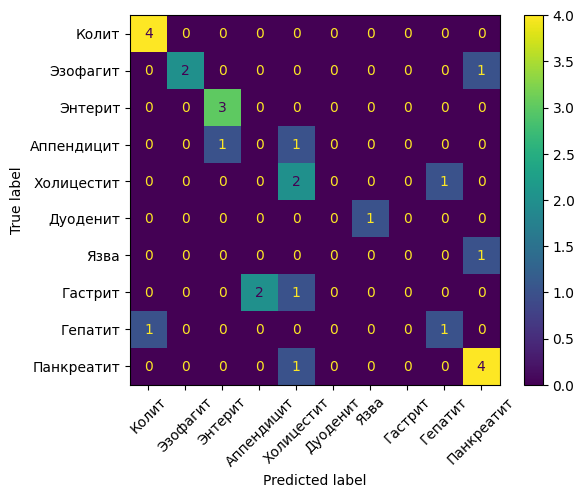


Модель правильно распознала 6 из 10 классов


In [50]:
# Оценка качества модели
y_pred = model.predict(x_test)  # Прогнозы модели на тестовых данных
y_pred_classes = np.argmax(y_pred, axis=1) # Преобразуем вероятности в классы
y_true = np.argmax(y_test, axis=1) # Преобразуем вероятности в классы

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
disp.plot(xticks_rotation=45)
plt.show()

correct_classes = sum(cm[i][i] > 0 for i in range(CLASS_COUNT))
print(f'\nМодель правильно распознала {correct_classes} из {CLASS_COUNT} классов')

In [51]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'\nТочность на тестовой выборке: {accuracy:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5926 - loss: 1.0671

Точность на тестовой выборке: 0.5926


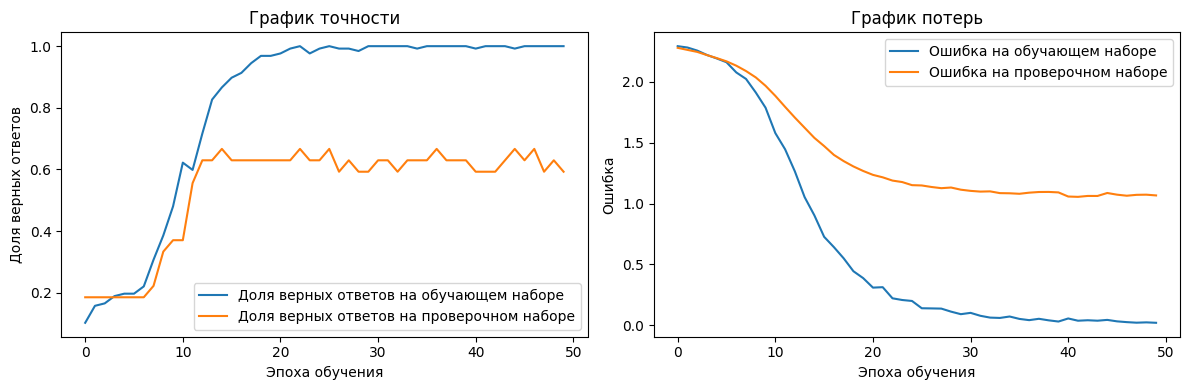

In [52]:
import matplotlib.pyplot as plt

# Построение графиков обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
    plt.title('График точности')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title('График потерь')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Применение функции к вашей истории обучения
plot_training_history(history)